In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams


In [19]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)


In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

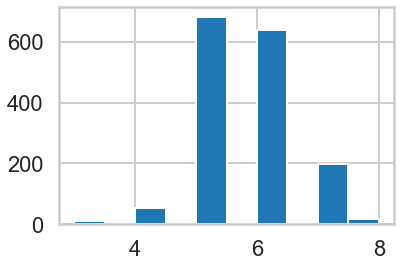

In [6]:
print (df.shape)

plt.hist(df.quality)

In [7]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
Xnames = list(df.columns.values[1:11])


In [9]:
np.mean(df['target'])

0.1357098186366479

In [13]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [14]:
print ("% Good wines in Training:", np.mean(df.target[mask]))
print ("% Good wines in Testing:", np.mean(df.target[~mask]))

% Good wines in Training: 0.13660062565172054
% Good wines in Testing: 0.134375


In [20]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 2, 'min_samples_leaf': 1} 0.42719117986672633 {'mean_fit_time': array([0.00631928, 0.00068192, 0.0010016 , 0.00276256, 0.00132904,
       0.00040665, 0.00236521, 0.00218253, 0.00040145, 0.00133448,
       0.00080128, 0.00312462, 0.00140753, 0.        , 0.        ,
       0.        , 0.        , 0.00039868, 0.00314288, 0.00625262,
       0.00367727, 0.003128  , 0.00033021, 0.00314288, 0.        ,
       0.00312424, 0.00039864, 0.        , 0.        , 0.00312386,
       0.00312462, 0.00312386, 0.00383363, 0.00312462, 0.00625668,
       0.00020723, 0.00020752, 0.00404086, 0.        , 0.00312757,
       0.00304384, 0.00082097]), 'std_fit_time': array([0.00504021, 0.00066204, 0.00070155, 0.0012168 , 0.00032207,
       0.00049817, 0.0013747 , 0.00166565, 0.0008029 , 0.0017284 ,
       0.00160255, 0.00624924, 0.0015021 , 0.        , 0.        ,
       0.        , 0.        , 0.00048829, 0.00628576, 0.00765787,
       0.00611708, 0.00625601, 0.00066042, 0.00628576

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


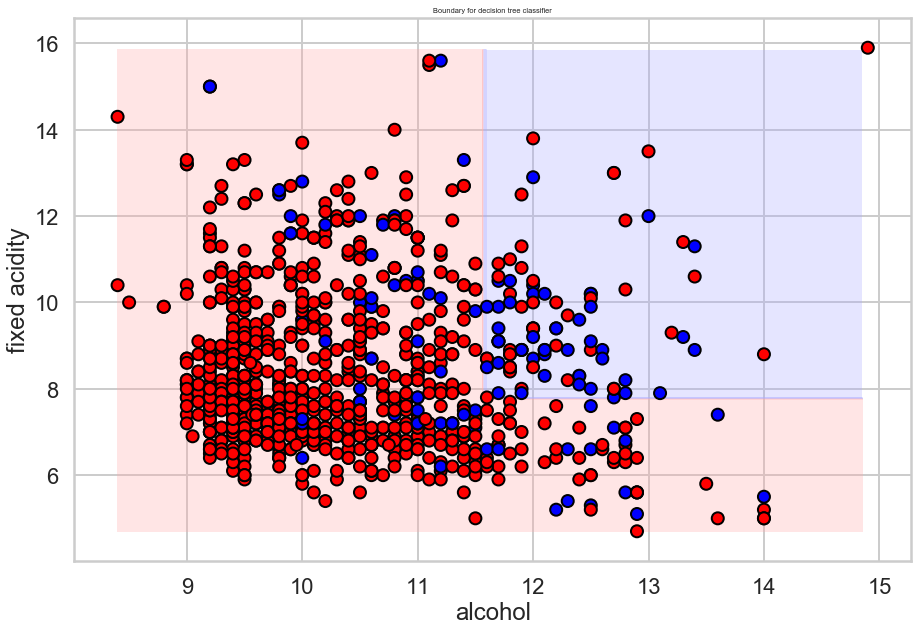

In [23]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)



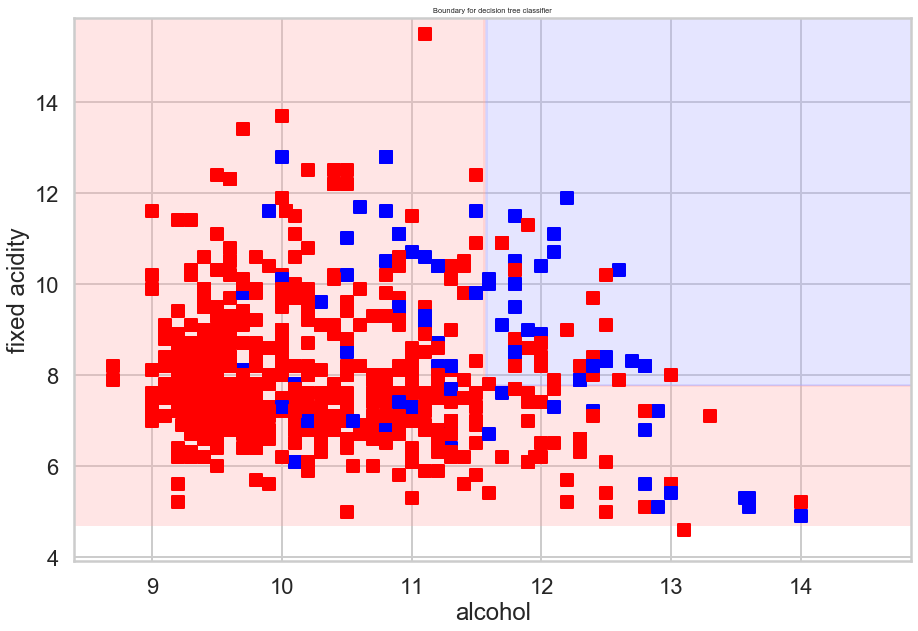

In [22]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

using mask
BEST {'max_depth': None, 'min_samples_leaf': 6} 0.2795224167534726 {'mean_fit_time': array([0.00335851, 0.00096178, 0.00336366]), 'std_fit_time': array([0.00249277, 0.00085677, 0.00089605]), 'mean_score_time': array([0.00192084, 0.00188222, 0.0008698 ]), 'std_score_time': array([0.00192273, 0.0017538 , 0.00077917]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': None, 'min_samples_leaf': 4}, {'max_depth': None, 'min_samples_leaf': 5}, {'max_depth': None, 'min_samples_leaf': 6}], 'split0_test_score': array([0.125, 0.125, 0.125]), 'split1_test_score': array([0.26923077, 0.25      , 0.31578947]), 'split2_test_score': array([0.34146341, 0.38095238, 0.35      ]), 'split3_test_score': array([0.35483871, 0.38709677

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


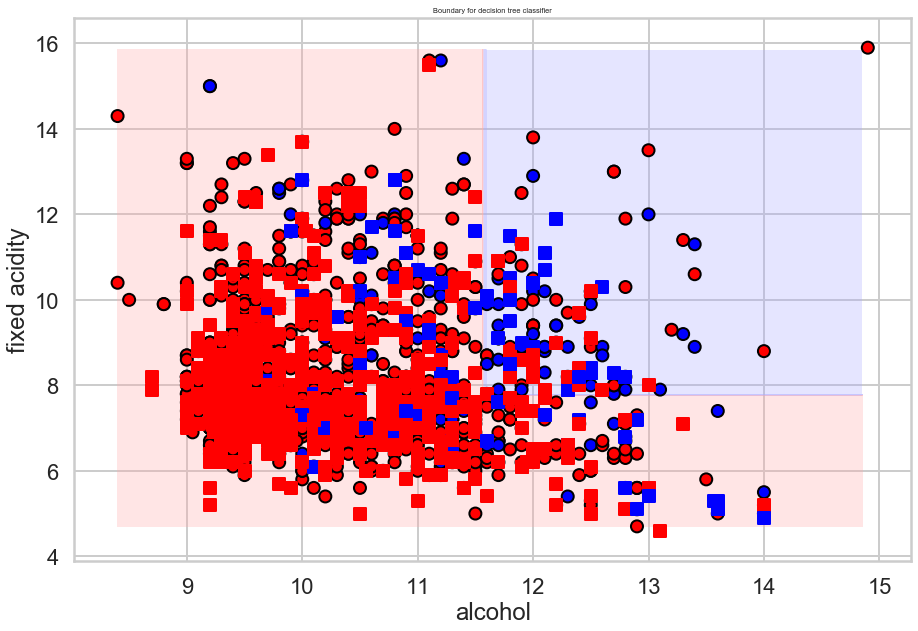

In [24]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

In [25]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 2, 'min_samples_leaf': 1} 0.45692473587139715 {'mean_fit_time': array([0.00133572, 0.00127392, 0.00125022, 0.00158105, 0.00080447,
       0.00198765, 0.00270925, 0.0008287 , 0.00126915, 0.00202622,
       0.00289969, 0.00056462, 0.00135818, 0.00396748, 0.00187483,
       0.00468092, 0.00297794, 0.00476232, 0.00283689, 0.00329194,
       0.00354419, 0.00337491, 0.00296302, 0.00413356, 0.00285993,
       0.00308094, 0.00027876, 0.00369787, 0.00364761, 0.00407867,
       0.00627651, 0.00668039, 0.00369964, 0.00467658, 0.00511684,
       0.00627775, 0.0064836 , 0.00519609, 0.00466318, 0.00407062,
       0.00647979, 0.00312462, 0.00624862, 0.00829144, 0.00372982,
       0.009409  , 0.00937314, 0.00624862, 0.00336409, 0.00625157,
       0.00937314, 0.00705624, 0.00312843, 0.00837975, 0.00544419,
       0.00262842, 0.        , 0.00990539, 0.        , 0.00652204,
       0.00937309, 0.00624819, 0.00312438, 0.00749583, 0.00750394,
       0.00692372, 0.00735145, 0.00

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 12} 0.3858967696663453 {'mean_fit_time': array([0.01352229, 0.01299381, 0.0126524 , 0.01964574, 0.0231154 ,
       0.03072886, 0.03387156, 0.04183378, 0.04250145, 0.04199739,
       0.05266666, 0.06343231, 0.05478187, 0.06354322, 0.08273811,
       0.07950182, 0.08526902, 0.08458242, 0.0829464 ]), 'std_fit_time': array([0.00425946, 0.00329383, 0.00312188, 0.0079043 , 0.00186683,
       0.00503719, 0.00282146, 0.01410793, 0.00571976, 0.00438378,
       0.00723393, 0.01048162, 0.00634636, 0.00548511, 0.00918615,
       0.01571643, 0.00936471, 0.01682701, 0.0148639 ]), 'mean_score_time': array([0.00312433, 0.00230107, 0.00160151, 0.00564566, 0.00310097,
       0.00977559, 0.00311661, 0.00624914, 0.00410705, 0.00531373,
       0.00312462, 0.00283117, 0.00625191, 0.00322156, 0.00335102,
       0.00392494, 0.00082011, 0.00312433, 0.00474334]), 'std_score_time': array([0.00624866, 0.00209802, 0.00196144, 0.00537072, 0.00262145,
       0.00717873, 0.00623322, 0

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


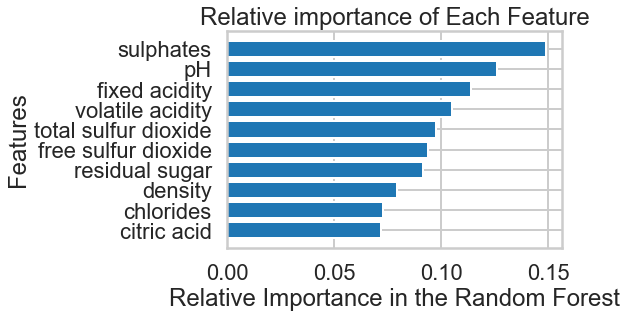

In [27]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [28]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 10} 0.42985266015927937 {'mean_fit_time': array([0.03830113, 0.04658875, 0.05002747, 0.0501832 , 0.05618691,
       0.0595871 , 0.07261744, 0.06950674, 0.06983886, 0.06952033,
       0.07108884, 0.09678602, 0.09629579, 0.09719086, 0.10234737,
       0.09960237, 0.12213478, 0.11404066, 0.11475282, 0.11873593,
       0.12878942, 0.13787203, 0.15047545, 0.14977183, 0.1510735 ,
       0.15023923, 0.14406362, 0.17018123, 0.17239032, 0.17497044,
       0.16431503, 0.16004205, 0.16089559, 0.1781106 , 0.16745243,
       0.17746625, 0.1761816 , 0.18233118, 0.18405652, 0.19897432,
       0.20477338, 0.22373466, 0.21813297, 0.19689617, 0.2158041 ,
       0.25632281, 0.24510412, 0.24810472, 0.25376496, 0.24104233]), 'std_fit_time': array([0.00165198, 0.00993219, 0.0103508 , 0.00309722, 0.0103739 ,
       0.00678588, 0.00855398, 0.00412822, 0.00427172, 0.0037364 ,
       0.00656416, 0.01732643, 0.00795385, 0.01821941, 0.01080546,
       0.00761567, 0.01930267, 0.006

c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'max_depth': 5, 'n_estimators': 51} 0.38883274423344116 {'mean_fit_time': array([0.08419323, 0.03875985, 0.03859568, 0.03207908, 0.04483547,
       0.03845921, 0.03837872, 0.03793764, 0.04252343, 0.04486217,
       0.03902755, 0.04448771, 0.04800687, 0.04866943, 0.05032549,
       0.05507765, 0.05924582, 0.05144024, 0.05025105, 0.05319271,
       0.05921812, 0.05037346, 0.047787  , 0.05859323, 0.0633604 ,
       0.05727167, 0.05612493, 0.05775208, 0.06063261, 0.06285419,
       0.04640737, 0.0488852 , 0.0468503 , 0.05408487, 0.05425644,
       0.05350113, 0.05369444, 0.05616107, 0.05887175, 0.06553774,
       0.06844287, 0.06645226, 0.06909957, 0.06190882, 0.06282692,
       0.06614337, 0.06537194, 0.06160383, 0.05646038, 0.06496897,
       0.07305374, 0.07771916, 0.07641125, 0.07788935, 0.08769345,
       0.07598867, 0.08360314, 0.0897893 , 0.08581753, 0.09681878,
       0.07247772, 0.08001466, 0.07235861, 0.07041388, 0.06830268,
       0.07063937, 0.08465648, 0.08615146, 0.0865

############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.91
[[540  14]
 [ 44  42]]
########################################################


In [31]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

In [32]:
clfForest.feature_importances_

array([0.11368695, 0.1051304 , 0.07169157, 0.09157799, 0.07265741,
       0.09380069, 0.0974328 , 0.07915852, 0.12587957, 0.14898412])

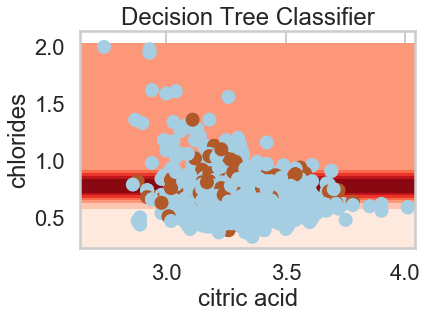

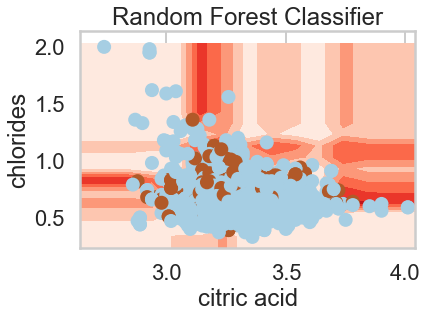

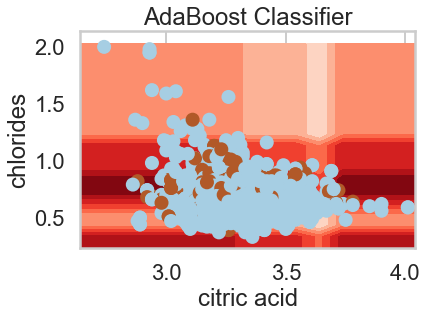

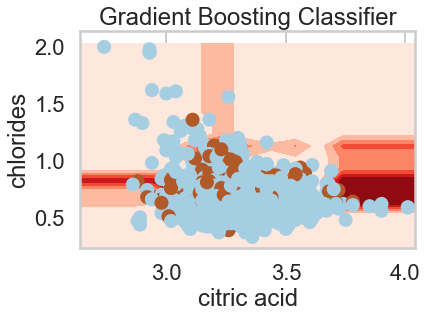

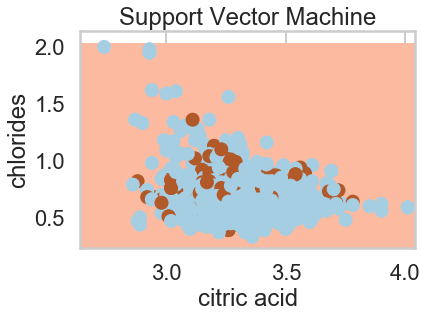

In [39]:
X_imp = df[['pH', 'sulphates']].values
Y = df.target.values

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in range(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)